In [1]:
%load_ext autoreload
%autoreload 2
from sparse_causal_model_learner_rl.keychest_vae.data import learner, h, w, c, engine, plot_data, get_dataloader
from sparse_causal_model_learner_rl.keychest_vae.vae import ObsNet, ObsModel
import gin
import numpy as np
from matplotlib import pyplot as plt
import torchvision
from torch.autograd import Variable
%matplotlib inline

Make environment KeyChest-v0 None {}


In [2]:
learner, engine, (h, w, c)

(<Learner env=<KeyChestGymEnv<KeyChest-v0>> feature_shape=(30,) epochs=0>,
 (12, 7, 11))

In [3]:
train_loader = get_dataloader(20)
eval_loader = get_dataloader(20)

Make environment KeyChest-v0 None {}



3.0
3.0
Make environment KeyChest-v0 None {}



3.0
3.0


In [4]:
?plot_data

Signature: plot_data(x, gx=3, gy=8, figsize=(15, 10))
Docstring: <no docstring>
File:      ~/causality-disentanglement-rl/sparse_causal_model_learner_rl/keychest_vae/data.py
Type:      function


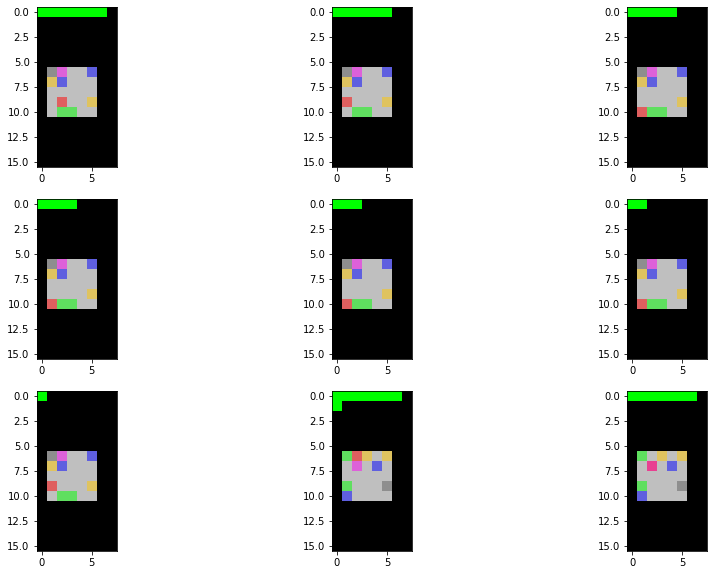

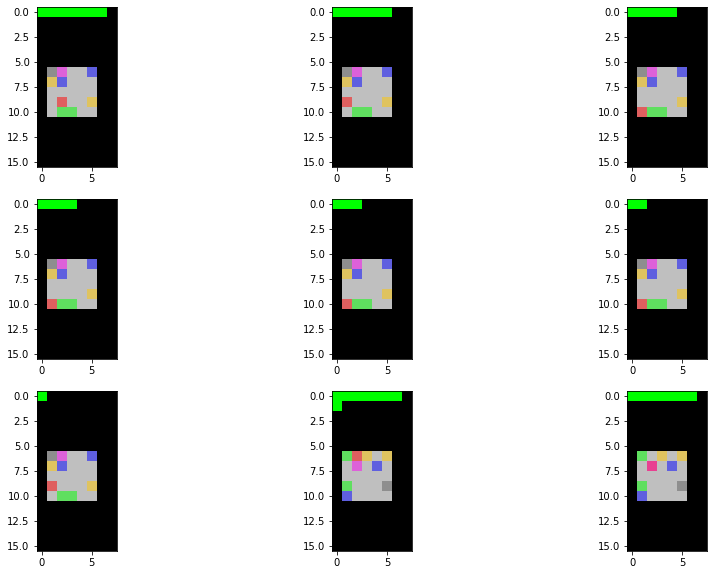

In [5]:
plot_data(np.rollaxis(train_loader.dataset.tensors[0].numpy(), 1, 4), gx=3, gy=3)

In [6]:
gin.bind_parameter('ObsNet.kernel_sizes', [3, 3, 2])
gin.bind_parameter('ObsNet.strides', [1, 1, 1])
gin.bind_parameter('ObsNet.channels', [3, 32, 32])

gin.bind_parameter('ObsNet.paddings', [0, 0, 1])
gin.bind_parameter('ObsNet.last_conv', False)
gin.bind_parameter('ObsNet.add_gan', True)


gin.bind_parameter('ObsNet.hid_x', 13)
gin.bind_parameter('ObsNet.hid_y', 5)

In [7]:
img = train_loader.dataset.tensors[0][0:1].cuda()

In [9]:
m = ObsModel(train_loader, eval_loader)

creating optimizers


In [10]:
m.model.apply_gan(img)

tensor([[0.5052]], device='cuda:0', grad_fn=<SigmoidBackward>)

In [11]:
[x.shape for x in m.model.apply_conv(img)], [x.shape for x in m.model.apply_deconv(m.model.apply_conv(img)[-1])]

([torch.Size([1, 3, 16, 8]),
  torch.Size([1, 3, 14, 6]),
  torch.Size([1, 32, 12, 4]),
  torch.Size([1, 32, 13, 5])],
 [torch.Size([1, 32, 13, 5]),
  torch.Size([1, 32, 12, 4]),
  torch.Size([1, 3, 14, 6]),
  torch.Size([1, 3, 16, 8])])

In [12]:
np.mean((train_loader.dataset.tensors[0] - train_loader.dataset.tensors[2]).numpy())

0.0022820502

In [ ]:
for _ in range(10000):
    print(m.train())

/home/serge/miniconda3/envs/causal/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


{'train_bce': 6550.0283203125, 'train_kld': 0.6564382314682007, 'train_mae': 0.45692697167396545, 'train_mse': 0.222210094332695, 'train_vae': 6550.6845703125, 'train_gan_true': 0.6826352477073669, 'train_gan_gen': 0.7039895057678223, 'train_gan': 1.386624813079834, 'train_total': 6552.0712890625}
{'train_bce': 6532.03955078125, 'train_kld': 0.8185725212097168, 'train_mae': 0.4559597373008728, 'train_mse': 0.22123490273952484, 'train_vae': 6532.85791015625, 'train_gan_true': 0.6888588666915894, 'train_gan_gen': 0.696415901184082, 'train_gan': 1.3852747678756714, 'train_total': 6534.2431640625}
{'train_bce': 6506.4140625, 'train_kld': 1.3792800903320312, 'train_mae': 0.45461612939834595, 'train_mse': 0.21984702348709106, 'train_vae': 6507.79345703125, 'train_gan_true': 0.6925985217094421, 'train_gan_gen': 0.6924803256988525, 'train_gan': 1.3850789070129395, 'train_total': 6509.1787109375}
{'train_bce': 6481.826171875, 'train_kld': 2.55378794670105, 'train_mae': 0.45334529876708984, 'tra

In [369]:
m.eval()

{'eval_loss': 3.1730690002441406, 'eval_mae': 0.028638387098908424}

In [370]:
# mnist = torchvision.datasets.MNIST("./mnist", train=True, download=True, transform=transforms.Compose([
#                                                               transforms.ToTensor(), # first, convert image to PyTorch tensor
#                                                           ]))
# action_dummy = TensorDataset(torch.zeros((len(mnist), 4)))
# mnist_loader = DataLoader(mnist, batch_size=512, shuffle=True)

# gin.bind_parameter('ObsNet.input_channels', 1)
# gin.bind_parameter('ObsNet.hid_x', 14)
# gin.bind_parameter('ObsNet.hid_y', 14)

# m = ObsModel(mnist_loader)

In [405]:
def get_images(m, loader):
    m.model.eval()
    _, (states, actions, next_states) = next(enumerate(loader))
    states = Variable(states).cuda()
    actions = Variable(actions).cuda()
    next_states = Variable(next_states).cuda()

    # mnist
    # states = next(enumerate(m.train_loader))[1][0].cuda()
    # actions = torch.zeros((states.shape[0], 4)).cuda()
    # next_states = states
    
    out, _, _ = m.model(states, actions)
    out = np.rollaxis(out.detach().cpu().numpy(), 1, 4)
    return out

In [406]:
train_images = get_images(m, train_loader)
eval_images = get_images(m, eval_loader)
demo_images = np.rollaxis(train_loader.dataset.tensors[0].numpy(), 1, 4)

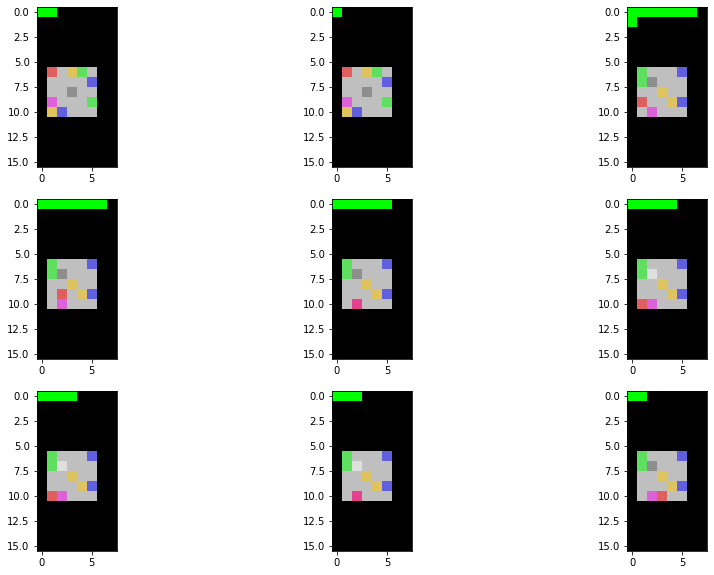

In [407]:
_ = plot_data(demo_images, gy=3)

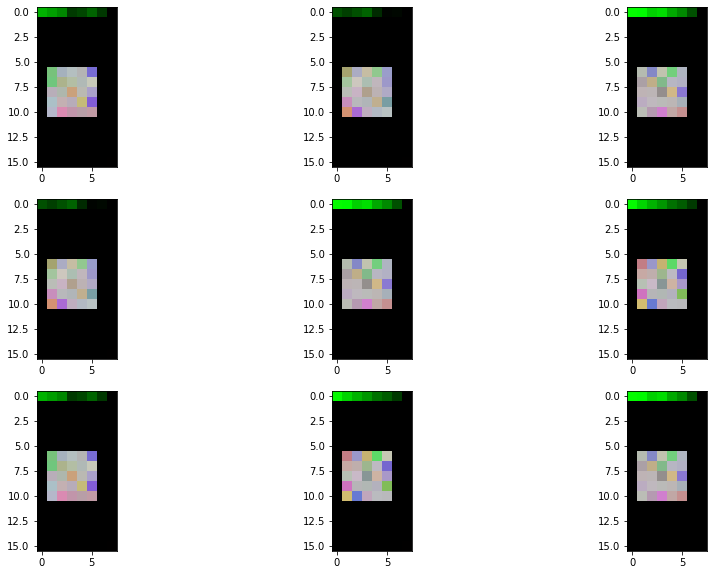

In [408]:
_ = plot_data(train_images, gy=3)

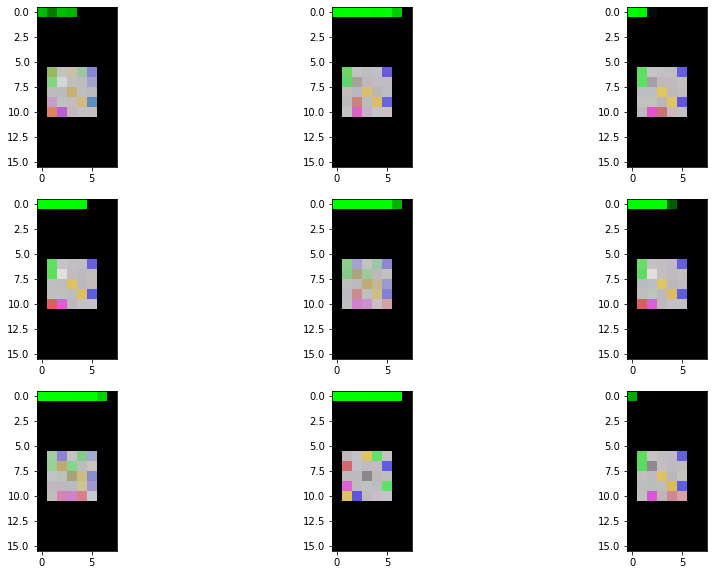

In [375]:
_ = plot_data(eval_images, gy=3)

In [376]:
train_image_idx = np.random.choice(range(len(train_images)))
eval_image_idx = np.random.choice(range(len(eval_images)))
demo_image_idx = np.random.choice(range(len(demo_images)))


train_image = train_images[train_image_idx]
eval_image = eval_images[eval_image_idx]
demo_image = demo_images[demo_image_idx]

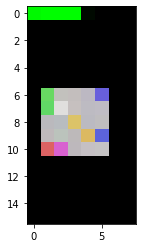

In [377]:
plt.imshow(eval_image)

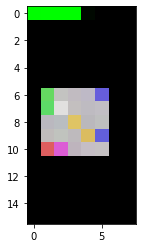

In [378]:
plt.imshow(train_image)

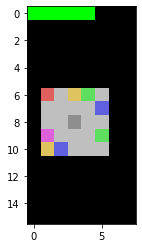

In [379]:
plt.imshow(demo_image)